# Try the extreme deconvolution code

4
[ 20090.96540048  20099.95181791  17623.93191137  15942.19475995
  15951.11281514  15955.13346839  15964.60699762  15974.34149556
  15983.28374029  15991.62424254]
[ 0.30658637  0.08600943  0.19556807  0.41183613]
[[ -5.02458593]
 [ 10.74972778]
 [  0.03347736]
 [  9.85813876]]


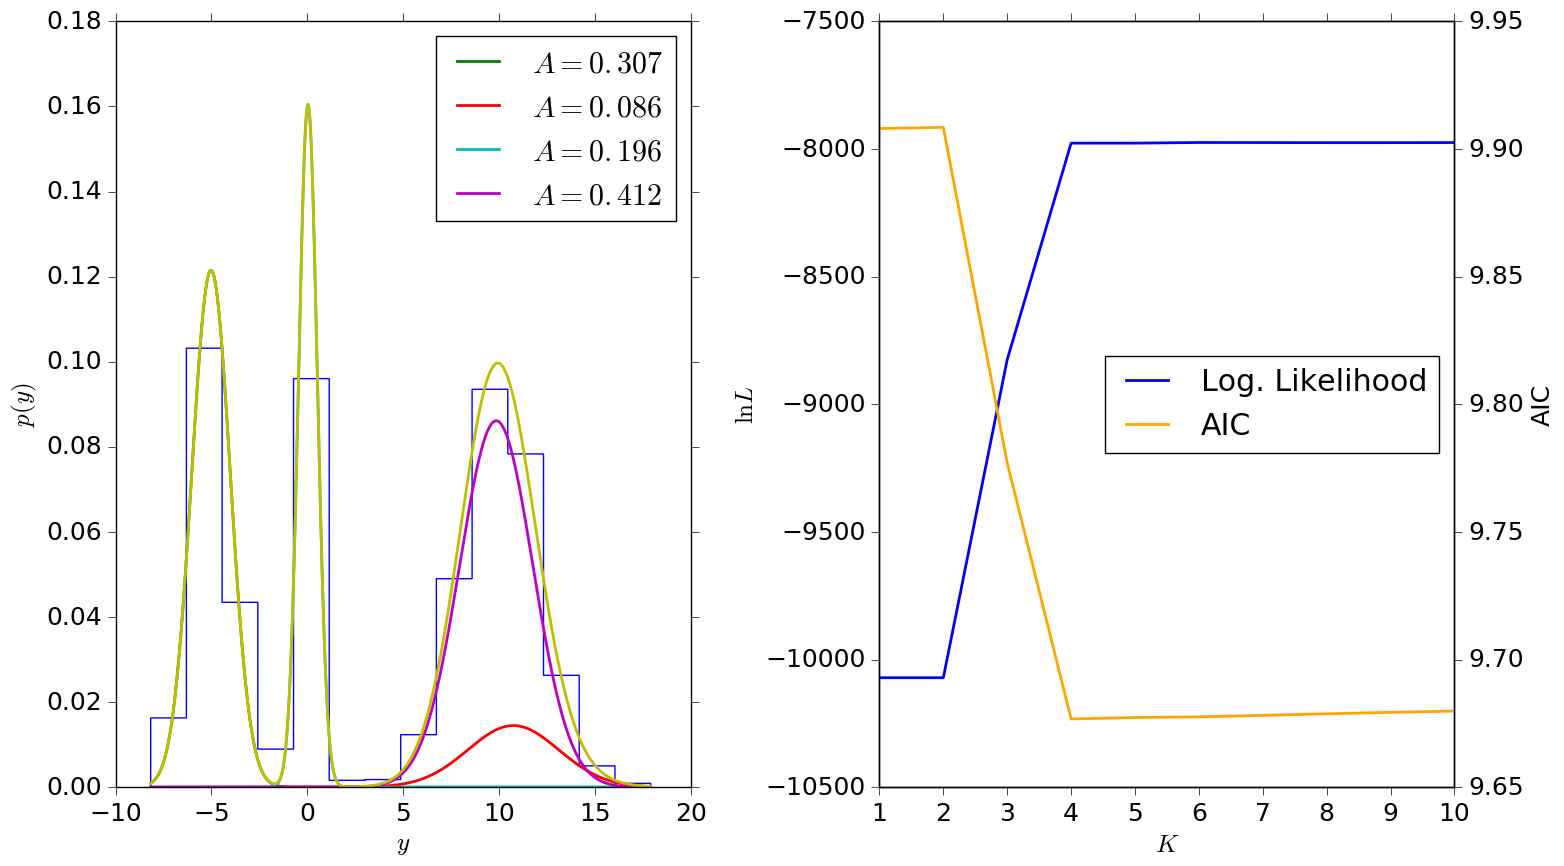

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from extreme_deconvolution.extreme_deconvolution import extreme_deconvolution as xd
from scipy.stats import norm, multinomial

rc('font', family='sans', size=18)
rc('xtick.major', size='6')
rc('xtick.minor', size='4')
rc('ytick.major', size='6')
rc('ytick.minor', size='4')
rc('lines', linewidth=2.0)
rc('axes', linewidth=1)
rc('xtick', direction='out')
rc('ytick', direction='out')
rc('grid', color='cbcbcb')
rc('grid', linestyle='-')
rc('grid', linewidth=0.5)
rc('grid', alpha=1.0)
rc('figure', facecolor='ffffff')
rc('figure', dpi=80)
rc('figure.subplot', bottom=0.125)

#np.random.seed(2)

ndata = 3001
ncomponents = 3
amps_true = [0.3, 0.2, 0.5]
assign = multinomial.rvs(1,amps_true,size=ndata)
ydata = np.zeros((ndata,1))
ydata[assign[:,0]==1,0] = np.random.normal(size=np.sum(assign[:,0]==1))-5.
ydata[assign[:,1]==1,0] = np.random.normal(size=np.sum(assign[:,1]==1))*0.5
ydata[assign[:,2]==1,0] = np.random.normal(size=np.sum(assign[:,2]==1))*2.+10.
ycovar = np.zeros_like(ydata)

paramsPerComp = 3
Kmax=10
Karray = np.arange(1,Kmax+1)
logL = np.zeros(Kmax)
aic = np.zeros(Kmax)
logLmax = -np.inf
aicMin = np.inf
numComponents = None
amps = None
means = None
covar = None

for K in Karray:
    initamp = np.ones(K)/float(K)
    initmean = np.random.uniform(low=ydata.min(), high=ydata.max(), size=(K,1))
    #initmean = np.reshape(ydata.min() + (np.arange(K)+1) * (ydata.max()-ydata.min())/(K+1), (K,1))
    initcovar = np.zeros((K,1,1))
    for kk in range(K):
        initcovar[kk]= np.mean(3.*np.var(ydata))

    logL[K-1] = xd(ydata,ycovar,initamp,initmean,initcovar)*ndata
    aic[K-1] = -(2.0/ndata)*(ndata-1.0-paramsPerComp-Kmax/2.0)*logL[K-1] + 3*K*paramsPerComp
    if aic[K-1]<aicMin:
        numComponents = K
        amps = initamp
        means = initmean
        covar = initcovar
        aicMin = aic[K-1]

print(numComponents)
print(aic)
print(amps)
print(means)

z = np.linspace(ydata.min(),ydata.max(),1000)
model = np.zeros_like(z)

fig, (axA, axB) = plt.subplots(1,2,figsize=(16,9))
axA.hist(ydata.flatten(), bins='auto', histtype='step', normed=True)
for kk in range(numComponents):
    comp = norm.pdf(z, loc=means[kk,0], scale=np.sqrt(covar[kk,0,0]))*amps[kk]
    model = model + comp
    axA.plot(z,comp, label='$A={0:.3f}$'.format(amps[kk]))
axA.plot(z,model,lw=2)
axA.set_xlabel('$y$')
axA.set_ylabel('$p(y)$')
axA.legend()

lns1 = axB.plot(Karray, logL, label='Log. Likelihood')
axBB = axB.twinx()
lns2 = axBB.plot(Karray, np.log(aic), color='orange', label='AIC')
axB.set_xlabel('$K$')
axB.set_ylabel('$\ln L$')
axBB.set_ylabel('AIC')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axB.legend(lns, labs, loc='center right')

plt.tight_layout()

plt.show()